# **Clasificador de Imágenes con Pytorch: Flores**

*Autores:* Luna Yue Hernández Guerra y Kimberly Casimiro Torres

## **Introducción**

El objetivo es desarrollar un clasificador de imágenes de flores utilizando una red convolucional con PyTorch. Este modelo se entrenará para reconocer diferentes tipos de flores, como la margarita, rosa, girasol, entre otros.

## **Conjuntos de Datos**

Para llevar a cabo el clasificador, debemos buscar un conjunto de datos con el cual probarlo. En este caso, hemos escogido un dataset de imágenes de flores. Dicho dataset se puede obtener en [Kaggle](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition/data). Su contenido consta de 5 subdirectorios que representan las distintas clases: margarita, diente de león, rosa, girasol y tulipán. Cada clase contiene entre 733 y 1052 imágenes distintas entre sí, con diferentes colores, formas y posiciones.

Para reproducir este experimento, es necesario guardar dicho dataset en la ruta data/flowers, resultando la siguiente estructura de directorios:

``` bash
data/
└── flowers/
    ├── daisy/
    ├── dandelion/
    ├── rose/
    ├── sunflower/
    └── tulip/
```

## **Métodos e Implementaciones**

### **Importación de Módulos y Librerías Necesarias**

In [2]:
import os
import cv2
import shutil
import torch
import optuna
import matplotlib
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from pathlib import Path
from PIL import ImageEnhance
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score

### **Optimización de Hiperparámetros con Optuna**

Este código implementa un proceso de optimización de hiperparámetros utilizando **Optuna**, un marco para optimizar parámetros de modelos de machine learning. El objetivo principal es encontrar los mejores valores de hiperparámetros para el modelo de red neuronal convolutiva (CNN) diseñado para clasificar imágenes de flores.

En primer lugar, vamos a utilizar la librería optuna para realizar una búsqueda automatizada de los mejores hiperparámetros. La red cuenta con 3 capas convolutivas, 1 capa de pooling, 2 capas fully-connected y dropout. Los hiperparámetros a estudiar son:

- Tamaño del batch (batch_size): Valores explorados: 16, 32, 64 y 128.
- Tasa de aprendizaje o learning rate (lr): Explorada en un rango logarítmico entre $10^{-5}$ y $10^{-1}$.
- Tasa de dropout (dropout_rate): Explorada entre 0.1 y 0.5.

Además, a los datos originales divididos en entrenamiento (80%) y prueba/validación (20%), les aplicamos transformaciones de reescalado, conversión a tensores y normalización de los canales RGB. Aparte, a los datos de entrenamiento se les aplican técnicas de aumento de datos (data augmentation) como inversiones horizontales, rotaciones y ajustes de brillo, contraste y saturación.

In [8]:
def objective(trial):
    # Selección de hiperparámetros
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Ruta de datos
    data_path = 'data/flowers'

    # Transformaciones para los datos
    transform_train = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Carga de datos y partición en conjuntos de entrenamiento y prueba
    full_data = datasets.ImageFolder(root=data_path, transform=transform_train)
    train_size = int(0.8 * len(full_data))
    test_size = len(full_data) - train_size
    train_data, test_data = random_split(full_data, [train_size, test_size])
    test_data.dataset.transform = transform_test

    # Creación de dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Definición del modelo CNN
    class ConvNet(nn.Module):
        def __init__(self, num_classes, dropout_rate):
            super(ConvNet, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
            self.fc1 = nn.Linear(128 * 8 * 8, 256)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc2 = nn.Linear(256, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    # Configuración del dispositivo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Inicialización del modelo, función de pérdida y optimizador
    num_classes = len(full_data.classes)
    model = ConvNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Entrenamiento
    epochs = 5
    for _ in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

# Optimización de hiperparámetros
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-29 13:55:34,024] A new study created in memory with name: no-name-77944572-fdca-4aeb-bea9-826aa6feba17
[I 2024-12-29 13:55:58,458] Trial 0 finished with value: 22.10648148148148 and parameters: {'batch_size': 16, 'lr': 0.009506362455214272, 'dropout_rate': 0.4956134028375757}. Best is trial 0 with value: 22.10648148148148.
[I 2024-12-29 13:56:22,556] Trial 1 finished with value: 65.39351851851852 and parameters: {'batch_size': 16, 'lr': 0.0026178202643822976, 'dropout_rate': 0.34599869034024733}. Best is trial 1 with value: 65.39351851851852.
[I 2024-12-29 13:56:44,250] Trial 2 finished with value: 24.421296296296298 and parameters: {'batch_size': 128, 'lr': 0.02475265331922874, 'dropout_rate': 0.34608317513584874}. Best is trial 1 with value: 65.39351851851852.
[I 2024-12-29 13:57:06,091] Trial 3 finished with value: 23.37962962962963 and parameters: {'batch_size': 64, 'lr': 0.014997386921005837, 'dropout_rate': 0.3847211784637409}. Best is trial 1 with value: 65.3935185185

Best hyperparameters: {'batch_size': 16, 'lr': 0.0008401932678065538, 'dropout_rate': 0.2250114762660445}


El proceso de optimización con **Optuna** identificó los mejores hiperparámetros para el modelo de red neuronal convolutiva (CNN), obteniendo un tamaño de lote (`batch_size`) de 16, una tasa de aprendizaje (`lr`) de aproximadamente 0.0008, y una tasa de dropout (`dropout_rate`) del 22.5%.  Estos valores representan una configuración óptima para maximizar la precisión y proporcionar un modelo robusto y eficiente.

In [9]:
batch_size = study.best_params['batch_size']
lr = study.best_params['lr']
dropout_rate = study.best_params['dropout_rate']

### **Clasificadores**

#### **1. Transformaciones y Carga de Datos**

En esta sección, se cargan y transforman las imágenes para prepararlas como entrada para el modelo de clasificación. Las imágenes se redimensionan a 64x64 píxeles para asegurar uniformidad, se convierten a tensores y se normalizan al rango [-1, 1] para facilitar el entrenamiento del modelo. Posteriormente, el conjunto de datos completo se divide en dos partes: un 80% para el entrenamiento del modelo y un 20% para la evaluación en el conjunto de prueba, asegurando que ambas divisiones mantengan la misma estructura y transformaciones.

In [10]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta de las imágenes
data_path = 'data/flowers'

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

#### **2. Definición de Modelos CNN**

Se definen tres modelos con arquitecturas de diferente complejidad. Cada modelo utiliza varias capas convolutivas y de pooling para extraer características de las imágenes, seguido de capas totalmente conectadas para la clasificación final.

##### **Modelo Básico: ConvNet**

Esta red se compone de tres capas convolutivas, una capa de pooling y dos capas fully-connected. Asimismo, en el método fordward se utiliza la función ReLu como función de activación.

Por otro lado, la red utiliza diferentes valores para los hiperparámetros kernel_size, stride y padding. Recordemos que el kernel_size hace referencia al tamaño del núcleo, el stride hace referencia a los 'pasos' o 'saltos' dados por el kernel y el padding hace referencia al número de píxeles agregados en los bordes.

In [11]:
class ConvNet(nn.Module):
    def __init__(self, classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##### **Modelo Avanzado: ConvNet2**

Esta red añade una capa convolutiva más que la red básica ConvNet ya definida.

In [12]:
class ConvNet2(nn.Module):
    def __init__(self, classes):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # print(x.shape)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

##### **Modelo Complejo: ConvNet3**

Esta red posee seis capas convolutivas, una de pooling, dos fully-connected y una capa de dropout. Esta última capa sirve para prevenir el sobreajuste ya que desactiva aleatoriamente neuronas durante el entrenamiento.

In [13]:
class ConvNet3(nn.Module):
    def __init__(self, classes):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        # print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### **3. Parada Temprana**

Se implementa un mecanismo de parada temprana para detener el entrenamiento si no se mejora la pérdida de validación después de un número de épocas consecutivas tolerance, evitando sobreajuste y ahorro de tiempo. Dicha mejora se compara con el valor de `min_delta`.

In [14]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_val_loss = float('inf')

    def __call__(self, validation_loss):
        if (self.best_val_loss - validation_loss) > self.min_delta:
            self.counter = 0  
            self.best_val_loss = validation_loss
        else:
            self.counter += 1 
        
        if self.counter >= self.tolerance:
            self.early_stop = True
            print("Parada temprana activada. No hay mejora en la pérdida de validación.")

#### **4. Entrenamiento y Evaluación**

##### **Función para Entrenar el Modelo por Época**

Esta función realiza una época de entrenamiento sobre el conjunto de datos de entrada. Durante esta etapa, procesa los datos en pequeños lotes, calculando primero las predicciones del modelo para cada lote. Luego, evalúa el error de las predicciones comparándolas con las etiquetas reales utilizando una función de pérdida. A continuación, ajusta los pesos del modelo mediante el proceso de retropropagación, que calcula los gradientes, y el optimizador, que actualiza los pesos para minimizar la pérdida. Al finalizar la época, la función calcula y devuelve la pérdida promedio acumulada y la precisión del modelo, lo que proporciona una evaluación del rendimiento del modelo durante esa fase de entrenamiento.

In [15]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_train_loss, accuracy

##### **Función para Evaluar el Modelo**

Esta función evalúa el rendimiento del modelo utilizando el conjunto de prueba. Para cada lote de datos en este conjunto, calcula las predicciones del modelo y evalúa el error comparándolas con las etiquetas reales mediante una función de pérdida. Además, registra las etiquetas reales y las predicciones generadas, lo que permite realizar análisis posteriores, como la creación de una matriz de confusión. Al finalizar, la función devuelve la pérdida promedio acumulada en el conjunto de prueba, la precisión del modelo y una lista con todas las etiquetas reales y las predicciones, proporcionando así una visión completa del desempeño del modelo en datos no vistos.

In [16]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy, all_labels, all_preds

##### **Función para Graficar Métricas**

Esta función muestra la gráfica de pérdidas y la gráfica de precisiones durante el entrenamiento para los conjuntos de entrenamiento y validación, y una matriz de confusión de este último conjunto.

In [17]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

def plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, classes):
 
    # Gráfico de pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses[:epochs_trained], label="Training Loss")
    plt.plot(range(1, epochs_trained + 1), test_losses[:epochs_trained], label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies[:epochs_trained], label="Training Accuracy")
    plt.plot(range(1, epochs_trained + 1), test_accuracies[:epochs_trained], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Test Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Matriz de confusión
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for true_label, pred_label in zip(all_labels, all_preds):
        confusion_matrix[true_label, pred_label] += 1

    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(confusion_matrix, cmap='Blues')
    plt.colorbar(cax)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

##### **Función para Entrenar el Modelo**

La siguiente función se encarga de entrenar al modelo. Para ello, tiene como hiperparámetro el modelo, los conjuntos de entrenamiento y test, la función de pérdida, el optimizador, la función de parada temprana si existe, el número de épocas a entrenar y la época en la que se empieza a evaluar la parada temprana si existe. Esto último sirve para modelos más complejos que tardan en encontrar mejoría durante las primeras épocas.

La dinámica es la siguiente: Se entrena el modelo con el conjunto de entrenamiento y la función `train_one_epoch()`, y mientras se usan los datos de validación para evaluar dicho modelo con la función `evaluate()`. Asimismo, se comprueba si se cumplen las condiciones de parada temprana y una vez finalizado el entrenamiento, se grafican los resultados.

In [18]:
def train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs, start_early_stop=1):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    epochs_trained = 0

    for epoch in range(epochs):
        # Entrenamiento por una época
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%")

        # Evaluación en el conjunto de prueba
        test_loss, test_accuracy, all_labels, all_preds = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

        # Early stopping
        if early_stopping:
            early_stopping(test_loss)
            if early_stopping.early_stop and epoch>start_early_stop:
                print(f"Entrenamiento detenido en la época {epoch + 1} debido a la parada temprana.")
                epochs_trained = epoch + 1
                break
    else:
        epochs_trained = epochs

    # Graficar resultados
    plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, model.classes)
    return model

## **Experimentos**

##### **Clasificador Básico - Sin Parada Temprana**

El siguiente clasificador se define con el modelo básico ConvNet que recordemos que tiene tres capas convolutivas. Luego, como función de pérdida escogeremos la entropía cruzada y como optimizador, el Adam. Por otro lado, no aplicamos la parada temprana y evaluaremos 50 épocas. ¿Qué ocurre si no implementamos la parada temprana?

Epoch 1, Training Loss: 1.2124720011596326, Training Accuracy: 48.537503620040546%
Epoch 1, Test Loss: 1.015972857122068, Test Accuracy: 60.648148148148145%
Epoch 2, Training Loss: 0.9314183664542658, Training Accuracy: 63.19142774399073%
Epoch 2, Test Loss: 0.9028132579944752, Test Accuracy: 65.74074074074075%
Epoch 3, Training Loss: 0.7534359834950279, Training Accuracy: 70.51838980596582%
Epoch 3, Test Loss: 0.9074976819532888, Test Accuracy: 66.08796296296296%
Epoch 4, Training Loss: 0.5771294250670407, Training Accuracy: 78.22183608456415%
Epoch 4, Test Loss: 0.9428602732993938, Test Accuracy: 67.36111111111111%
Epoch 5, Training Loss: 0.39412194466287337, Training Accuracy: 85.5198378221836%
Epoch 5, Test Loss: 1.0410267274688791, Test Accuracy: 62.84722222222222%
Epoch 6, Training Loss: 0.23222357093322057, Training Accuracy: 92.99160150593687%
Epoch 6, Test Loss: 1.3167831384473376, Test Accuracy: 63.31018518518518%
Epoch 7, Training Loss: 0.13681818591861952, Training Accuracy

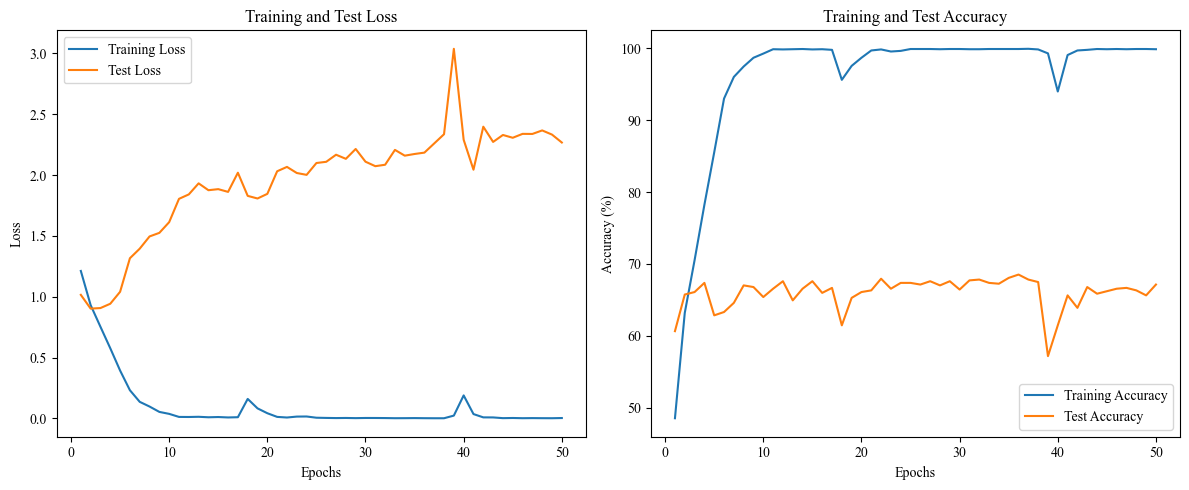

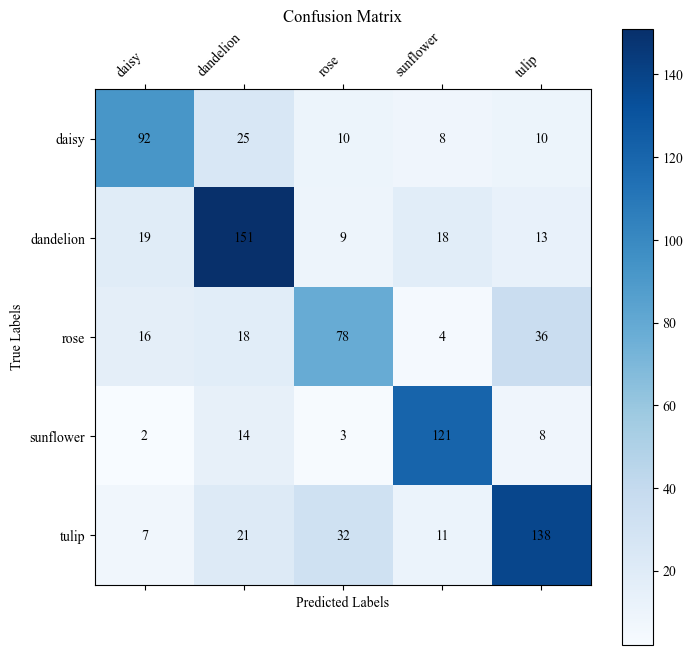

In [19]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, [], epochs=50)

Los resultados obtenidos muestran que el modelo logra aprender de manera efectiva durante las primeras épocas, como lo indican las gráficas de pérdida y precisión. Sin embargo, se observa un claro sobreajuste a medida que el entrenamiento avanza. La pérdida del conjunto de entrenamiento continúa disminuyendo mientras que la pérdida del conjunto de prueba se estabiliza o aumenta, acompañado de una precisión que no mejora significativamente en los datos de prueba. La matriz de confusión revela que el modelo tiene un buen desempeño en algunas clases, como "dandelion" y "tulip", pero presenta dificultades al diferenciar otras, como "daisy" y "rose". Esto sugiere que el modelo no generaliza de manera uniforme en todas las categorías. Para mejorar estos resultados, sería conveniente implementar técnicas como la parada temprana para mitigar el sobreajuste y mejorar la capacidad del modelo para generalizar.

##### **Clasificador Básico - Con Parada Temprana**

En este clasificador, vamos a añadir la implementación de la parada temprana para ver las diferencias. Definimos la tolerancia a 5 épocas y la mejora debe ser mayor a 0.01. Los demás parámetros los dejamos igual. Veremos qué ocurre:

Epoch 1, Training Loss: 1.2118138452922855, Training Accuracy: 47.66869388937156%
Epoch 1, Test Loss: 1.071881389176404, Test Accuracy: 56.8287037037037%
Epoch 2, Training Loss: 1.0085612623779863, Training Accuracy: 59.542426875181%
Epoch 2, Test Loss: 1.0316880819974121, Test Accuracy: 61.9212962962963%
Epoch 3, Training Loss: 0.877237337882872, Training Accuracy: 65.71097596293079%
Epoch 3, Test Loss: 0.9269782900810242, Test Accuracy: 64.35185185185185%
Epoch 4, Training Loss: 0.7063258414467176, Training Accuracy: 72.22704894294816%
Epoch 4, Test Loss: 0.969921503354002, Test Accuracy: 63.657407407407405%
Epoch 5, Training Loss: 0.5444200295541022, Training Accuracy: 80.07529684332465%
Epoch 5, Test Loss: 0.9982817139890459, Test Accuracy: 66.20370370370371%
Epoch 6, Training Loss: 0.35979727576314297, Training Accuracy: 88.0683463654793%
Epoch 6, Test Loss: 1.0921540271352839, Test Accuracy: 63.541666666666664%
Epoch 7, Training Loss: 0.22505860913682868, Training Accuracy: 92.47

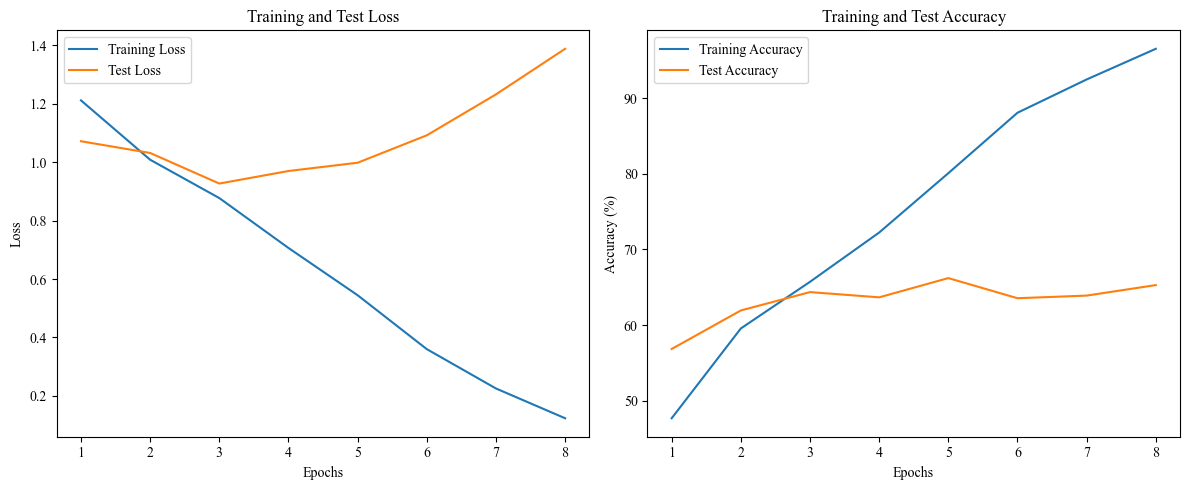

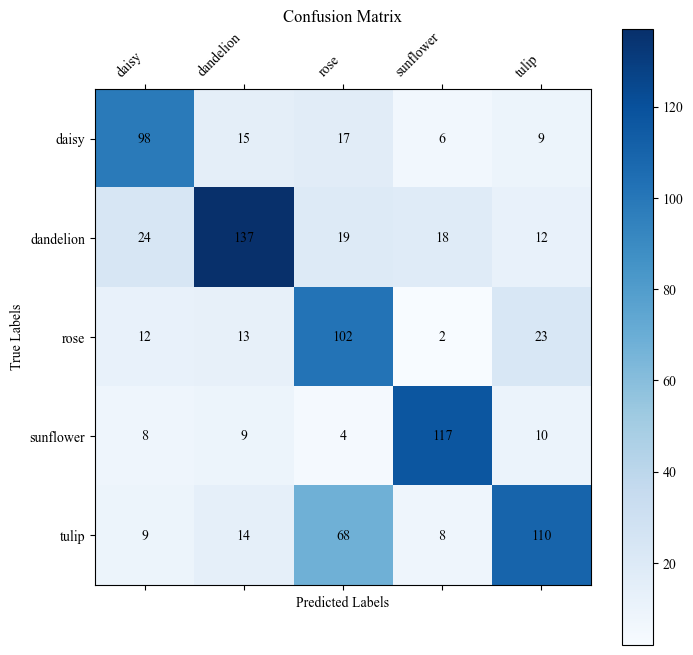

In [20]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

Con base en los resultados obtenidos, se observa que el modelo muestra un sobreajuste, ya que la pérdida del conjunto de entrenamiento disminuye mientras la pérdida del conjunto de prueba aumenta. Por ello, se aplica una función de parada temprana, deteniendo el entrenamiento en la época 8, cuando no se observa una mejora sustancial en los resultados. La precisión del conjunto de entrenamiento alcanzó un 96.5%, mientras que la precisión del conjunto de prueba se mantuvo en torno al 65%, indicando que el modelo logra aprender bien los datos de entrenamiento pero no generaliza correctamente a nuevos datos.

Dado este comportamiento, es necesario ajustar las configuraciones del modelo o probar con estrategias adicionales para mejorar el rendimiento y evitar el sobreajuste.

##### **Clasificador Básico - Con 4 capas convolutivas**

Para el siguiente caso, utilizaremos el clasificador `ConvNet2` con una capa convolutiva más.

Epoch 1, Training Loss: 1.2596425433401708, Training Accuracy: 44.36721691282943%
Epoch 1, Test Loss: 1.0940707690185971, Test Accuracy: 54.398148148148145%
Epoch 2, Training Loss: 1.042161539196968, Training Accuracy: 57.109759629307845%
Epoch 2, Test Loss: 0.9727026914004926, Test Accuracy: 62.73148148148148%
Epoch 3, Training Loss: 0.9105373212584743, Training Accuracy: 64.03127715030408%
Epoch 3, Test Loss: 0.9146527603820518, Test Accuracy: 65.04629629629629%
Epoch 4, Training Loss: 0.8159382862073404, Training Accuracy: 68.43324645236027%
Epoch 4, Test Loss: 0.8623685560844563, Test Accuracy: 65.97222222222223%
Epoch 5, Training Loss: 0.7313820305797789, Training Accuracy: 71.96640602374747%
Epoch 5, Test Loss: 0.7634545078984013, Test Accuracy: 70.7175925925926%
Epoch 6, Training Loss: 0.6327578244661843, Training Accuracy: 75.29684332464524%
Epoch 6, Test Loss: 0.7463549397609852, Test Accuracy: 71.75925925925925%
Epoch 7, Training Loss: 0.5466125220474269, Training Accuracy: 7

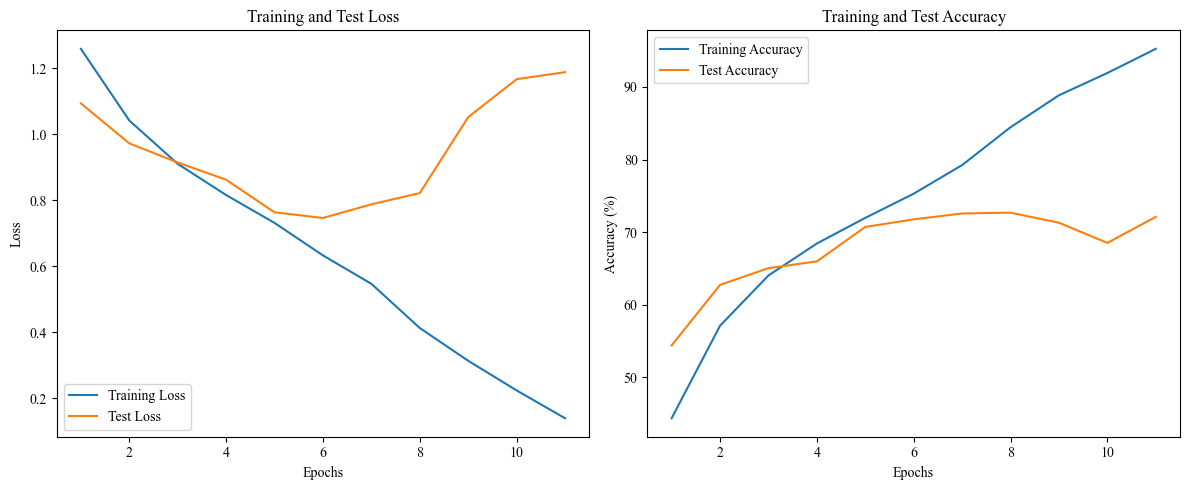

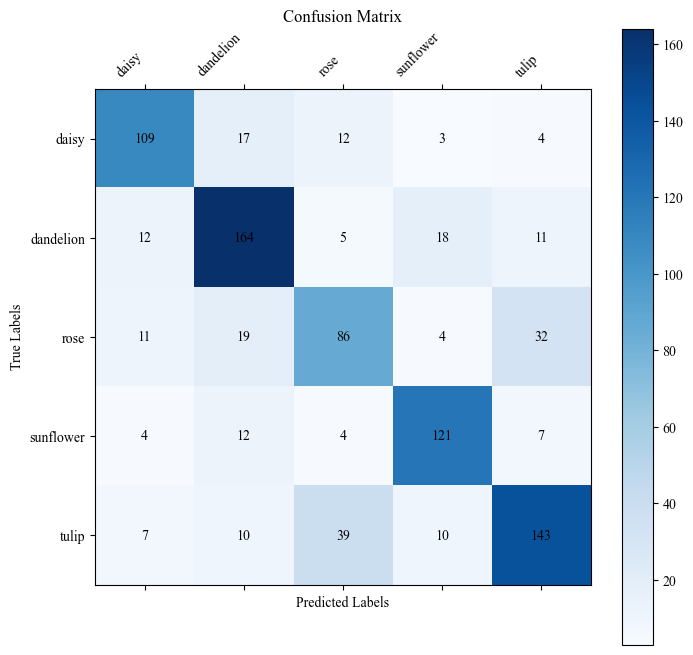

In [21]:
# Configuración inicial
model = ConvNet2(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

Los resultados muestran que el modelo con cuatro capas convolutivas presenta un buen desempeño en el conjunto de entrenamiento, alcanzando una precisión del 95%. Sin embargo, la precisión en el conjunto de prueba se mantiene alrededor del 72%, lo que indica una ligera falta de generalización a datos nuevos. La matriz de confusión refleja que las clases dandelion y sunflower tienen una alta precisión, mientras que rose y tulip presentan mayores confusiones con otras categorías. Esto podría deberse a características compartidas entre estas clases.

En general, los resultados son prometedores, pero sería necesario implementar ajustes adicionales para mejorar la generalización del modelo y reducir los errores en las clases menos precisas.

##### **Clasificador Básico - Con 6 capas convolutivas y Dropout**

Utilizamos ahora el clasificador `ConvNet3` que posee 6 capas convolutivas y una de dropout. Además, indicamos que active la parada temprana a partir de la época 10, ya que al tener más capas convolutivas, tarda más en mejorar durante el entrenamiento.

Epoch 1, Training Loss: 1.3731716126203537, Training Accuracy: 36.750651607298%
Epoch 1, Test Loss: 1.3814034086686593, Test Accuracy: 35.995370370370374%
Epoch 2, Training Loss: 1.2442308576018721, Training Accuracy: 44.54097885896322%
Epoch 2, Test Loss: 1.1366315020455255, Test Accuracy: 50.81018518518518%
Epoch 3, Training Loss: 1.1297894909426018, Training Accuracy: 52.8236316246742%
Epoch 3, Test Loss: 1.037600235806571, Test Accuracy: 57.291666666666664%
Epoch 4, Training Loss: 1.0034075089626842, Training Accuracy: 60.208514335360555%
Epoch 4, Test Loss: 1.0118830987700709, Test Accuracy: 61.574074074074076%
Epoch 5, Training Loss: 0.9051844365894794, Training Accuracy: 64.87112655661744%
Epoch 5, Test Loss: 0.8856738402887627, Test Accuracy: 65.16203703703704%
Epoch 6, Training Loss: 0.8122590919611631, Training Accuracy: 68.28844483058211%
Epoch 6, Test Loss: 0.8360694144611005, Test Accuracy: 67.82407407407408%
Epoch 7, Training Loss: 0.7204313760416375, Training Accuracy: 7

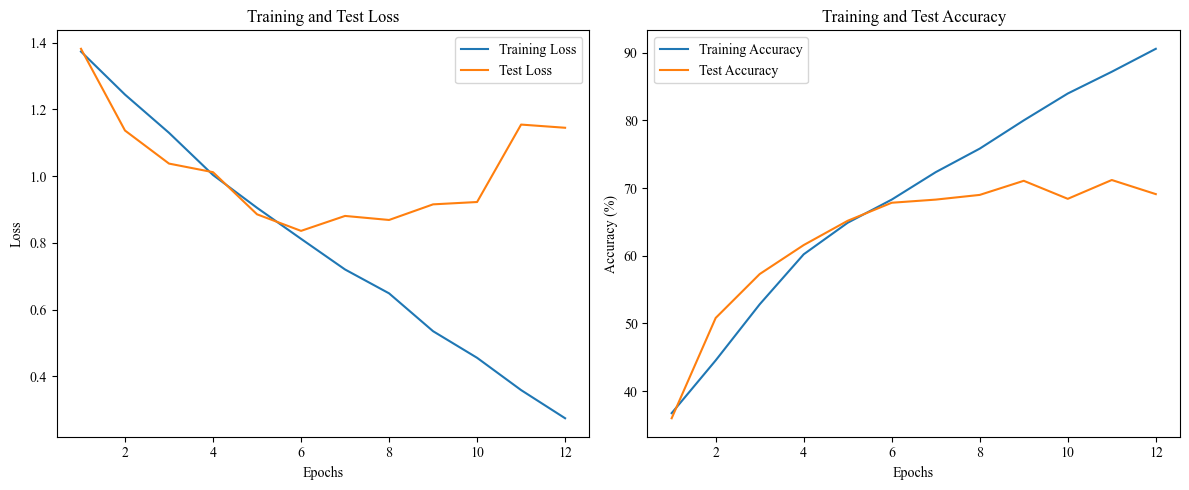

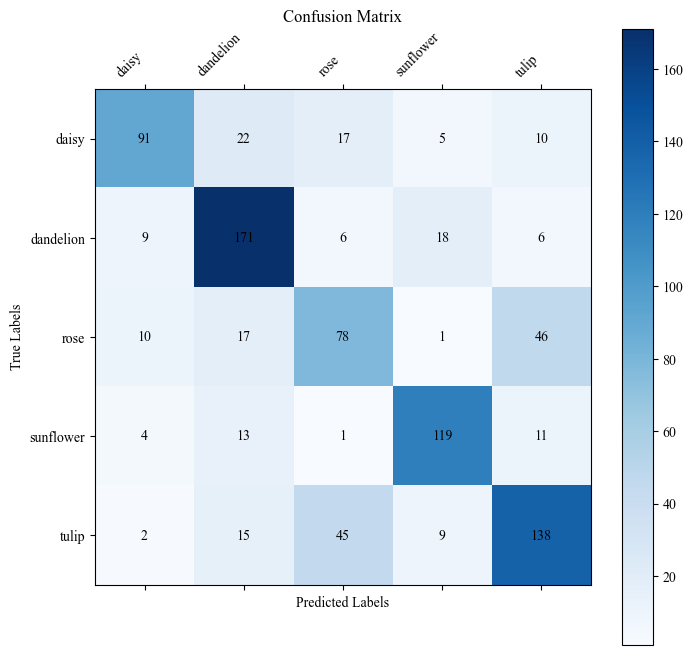

In [22]:
# Configuración inicial
model = ConvNet3(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

# Entrenamiento del Modelo
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Los resultados obtenidos con el modelo de seis capas convolutivas y la incorporación de dropout muestran una mejora moderada en la precisión del conjunto de prueba, alcanzando un 69%. Sin embargo, la matriz de confusión revela un aumento en las confusiones entre algunas clases en comparación con los modelos anteriores. Aunque dandelion y sunflower siguen destacándose con altos niveles de precisión, clases como rose y tulip presentan mayores errores, lo que sugiere que el modelo aún tiene dificultades para diferenciar ciertos patrones específicos. Esto podría estar relacionado con la complejidad de las características aprendidas o con la necesidad de un mayor equilibrio en los datos de entrada.

En conclusión, aunque el dropout ha ayudado a controlar el sobreajuste y mejorar la generalización, el incremento en las confusiones indica que aún son necesarios ajustes en la arquitectura del modelo o en el preprocesamiento de los datos para obtener un rendimiento más consistente.

## **ResNet-18**

ResNet-18 es un tipo de red residual que permite el desarrollo de redes más profundas sin que afecte el desvanecimiento del gradiente. Esto sucede gracias a los bloques o módulos residuales.

El desvanecimiento del gradiente es un problema al que se enfrenta toda red lo suficientemente profunda. Los valores de los gradientes se van despreciando debido a la gran profundidad de la red y el aprendizaje es casi insignificante.

Por tanto, este tipo de red utiliza unos módulos residuales que conectan las entradas con las salidas y evitan dicho desvanecimiento.

#### **1. Recorte de la Parte Superior en Imágenes**

Realizamos un recorte del 60% superior de las imágenes, ya que la parte inferior de las piezas son iguales.

In [23]:
def crop_top(img):
    width, height = img.size
    return img.crop((0, 0, width, int(height * 0.6)))

#### **2. Transformaciones y Carga de Datos**

Definimos la transformación de las imágenes con un recorte superior, redimensión de las mismas a un tamaño de e 224x224 píxeles (necesario para ResNet18), convertimos a tensor y normalizamos la imagen a un rango entre -1 y 1.

Luego, cargamos las imágenes, les aplicamos las transformaciones y las dividimos aleatoriamente en entrenamiento (80%) y validación (20%).

In [24]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Lambda(crop_top),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta de las imágenes
data_path = 'data/flowers'

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

#### **3. Entrenamiento del Modelo**

A continuación, entrenamos el modelo. Para ello, cargamos el modelo preentrenado ResNet18, definimos la función de pérdida y el optimizador, entrenamos 10 épocas y graficamos los resultados.

In [25]:
# Cargar un modelo preentrenado (ResNet18)
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(full_data.classes))  # Ajustar la salida al número de clases

# Definir optimizador y función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Entrenamiento
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {100 * correct / total}%")

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())  
            all_preds.extend(predicted.cpu().numpy())

            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {100 * correct / total}%")

C:\Users\kimbe\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kimbe\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Training Loss: 0.9143093218681989, Training Accuracy: 66.6956269910223%
Epoch 1, Test Loss: 0.6750163670491289, Test Accuracy: 76.1574074074074%
Epoch 2, Training Loss: 0.6573886102824299, Training Accuracy: 76.91862148856067%
Epoch 2, Test Loss: 0.9420905212561289, Test Accuracy: 65.50925925925925%
Epoch 3, Training Loss: 0.5851784195337031, Training Accuracy: 78.91688386909934%
Epoch 3, Test Loss: 0.7725524190399382, Test Accuracy: 72.91666666666667%
Epoch 4, Training Loss: 0.5285123588724269, Training Accuracy: 80.71242397914857%
Epoch 4, Test Loss: 0.5572097668493236, Test Accuracy: 79.86111111111111%
Epoch 5, Training Loss: 0.4367908469953195, Training Accuracy: 83.9270199826238%
Epoch 5, Test Loss: 0.5106976724885128, Test Accuracy: 81.59722222222223%
Epoch 6, Training Loss: 0.3601158885975127, Training Accuracy: 87.05473501303214%
Epoch 6, Test Loss: 0.6024386375038712, Test Accuracy: 77.43055555555556%
Epoch 7, Training Loss: 0.2867633039649162, Training Accuracy: 90.0

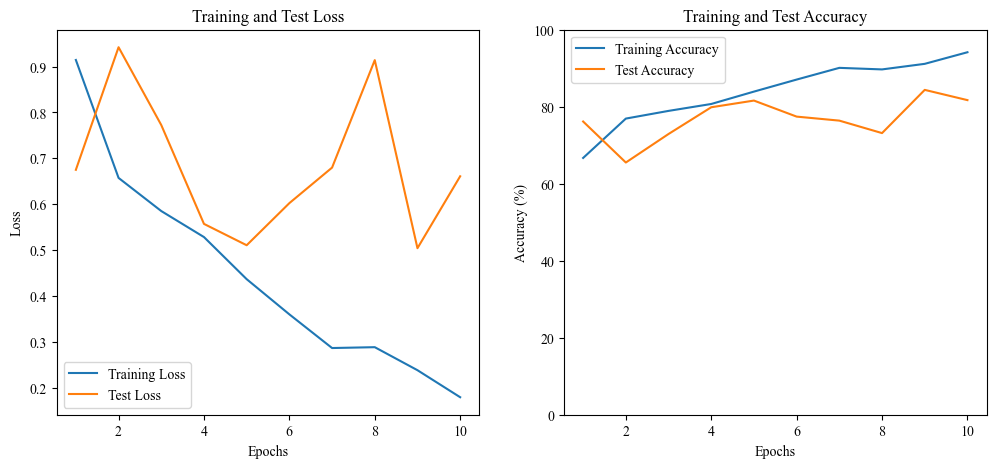

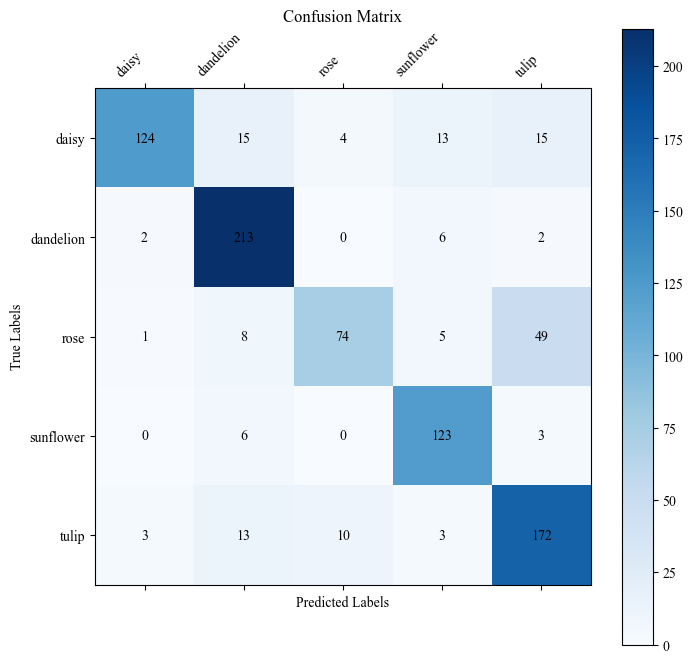

In [26]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Gráfico de pérdidas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100) 
plt.title("Training and Test Accuracy")
plt.legend()

# Matriz de Confusión
num_classes = len(full_data.classes)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(all_labels, all_preds):
    confusion_matrix[true_label, pred_label] += 1

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(confusion_matrix, cmap='Blues')
plt.colorbar(cax)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(full_data.classes, rotation=45, ha="right")
ax.set_yticklabels(full_data.classes)

for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Con los resultados obtenidos al implementar ResNet-18, se evidencia un rendimiento notablemente mejorado en comparación con arquitecturas anteriores. El modelo alcanzó una precisión del conjunto de prueba cercana al 82%, lo que indica un aprendizaje más robusto y generalizado. La matriz de confusión muestra que dandelion y tulip son las clases mejor clasificadas, con muy pocos errores en las predicciones. Sin embargo, aún persisten ciertas confusiones en clases como rose, que presenta errores significativos al ser confundida con otras categorías. Esto podría deberse a similitudes visuales entre las características de las clases involucradas.

En general, ResNet-18 demuestra una capacidad sobresaliente para manejar la complejidad del conjunto de datos y evitar problemas como el sobreajuste, gracias a su arquitectura residual.

## **VGG-16**

VGG-16 es una red convolucional que utiliza capas pequeñas de 3x3 para procesar información visual. 

Su diseño jerárquico permite extraer patrones simples en las primeras capas y complejos en las últimas.

A pesar de no contar con conexiones avanzadas, su estructura simple y profunda la hace eficiente y robusta. 

#### **1. Transformaciones y Carga de Datos**

Cargamos las imágenes, les aplicamos las transformaciones y las dividimos aleatoriamente en entrenamiento (80%) y validación (20%).

In [27]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta de las imágenes
data_path = 'data/flowers'

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))
test_size = len(full_data) - train_size

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

#### **2. Entrenamiento del Modelo**

A continuación, entrenamos el modelo. Para ello, cargamos el modelo preentrenado vgg16, definimos la función de pérdida y el optimizador, entrenamos 10 épocas y graficamos los resultados.

In [28]:
# Cargar un modelo preentrenado (VGG-16)
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

num_classes = len(full_data.classes)
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

# Definir optimizador y función de pérdida
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

# Entrenamiento
epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {100 * correct / total}%")

    vgg16.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = vgg16(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {100 * correct / total}%")

C:\Users\kimbe\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kimbe\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Training Loss: 0.6863061320726518, Training Accuracy: 73.96466840428613%
Epoch 1, Test Loss: 0.4211356551558883, Test Accuracy: 83.91203703703704%
Epoch 2, Training Loss: 0.3948010905749268, Training Accuracy: 85.83840139009557%
Epoch 2, Test Loss: 0.3860482628698702, Test Accuracy: 86.92129629629629%
Epoch 3, Training Loss: 0.28978437509525706, Training Accuracy: 89.6611642050391%
Epoch 3, Test Loss: 0.47859088855761067, Test Accuracy: 83.56481481481481%
Epoch 4, Training Loss: 0.20864135616769394, Training Accuracy: 92.78887923544744%
Epoch 4, Test Loss: 0.488360523349709, Test Accuracy: 85.18518518518519%
Epoch 5, Training Loss: 0.19113855991788484, Training Accuracy: 93.2812047494932%
Epoch 5, Test Loss: 0.4372220977588936, Test Accuracy: 85.5324074074074%
Epoch 6, Training Loss: 0.16083400620630495, Training Accuracy: 94.15001448016218%
Epoch 6, Test Loss: 0.5637855198648241, Test Accuracy: 82.06018518518519%
Epoch 7, Training Loss: 0.1586726647456763, Training Accuracy: 

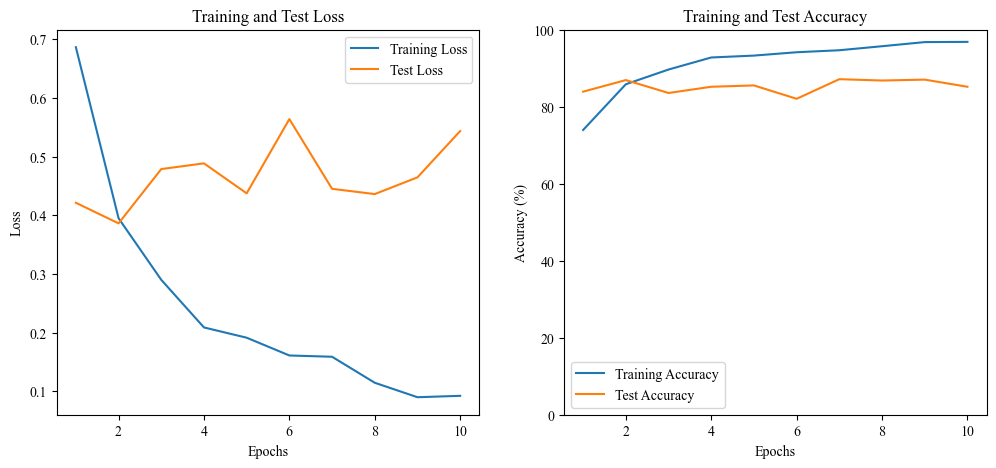

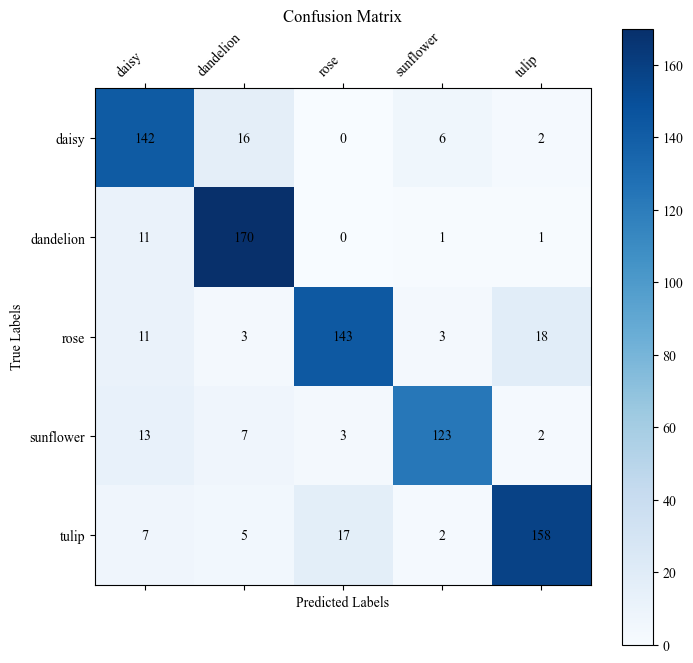

In [29]:
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Gráfico de pérdidas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100) 
plt.title("Training and Test Accuracy")
plt.legend()

# Matriz de Confusión
num_classes = len(full_data.classes)
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
for true_label, pred_label in zip(all_labels, all_preds):
    confusion_matrix[true_label, pred_label] += 1

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(confusion_matrix, cmap='Blues')
plt.colorbar(cax)
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(full_data.classes, rotation=45, ha="right")
ax.set_yticklabels(full_data.classes)

for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Con los resultados obtenidos al implementar el modelo VGG-16, se observa que este modelo ha sido el más eficiente en términos de precisión, alcanzando un 85% en el conjunto de prueba. Esto lo posiciona como la mejor opción entre las arquitecturas evaluadas, mostrando un excelente balance entre aprendizaje y generalización. En la matriz de confusión, las clases daisy y dandelion presentan los mejores resultados, con un alto número de predicciones correctas. Aunque existen pequeñas confusiones en algunas clases, el modelo demuestra una capacidad sólida para distinguir las categorías de manera precisa.

En conclusión, VGG-16 se establece como la arquitectura más adecuada para este problema, logrando una alta precisión.

## **Conclusión**


En conjunto, los experimentos realizados con diferentes arquitecturas de redes neuronales convolutivas han permitido evaluar diversas estrategias y configuraciones para abordar el problema. A lo largo de las pruebas, se observó un patrón consistente: los modelos más simples tienden a sobreajustarse rápidamente, mientras que las arquitecturas más avanzadas logran un mejor balance entre aprendizaje y generalización.

Las implementaciones con parada temprana demostraron ser útiles para mitigar el sobreajuste en modelos básicos, pero no fueron suficientes para resolver completamente los problemas de generalización. Al incorporar capas adicionales y técnicas como dropout, se observaron mejoras moderadas en la precisión del conjunto de prueba, aunque a costa de mayores confusiones en algunas clases específicas.

Las arquitecturas más avanzadas, como ResNet-18 y VGG-16, destacaron por su capacidad para manejar mejor la complejidad del conjunto de datos. ResNet-18 presentó un equilibrio sólido entre precisión y robustez, mientras que VGG-16 se posicionó como la mejor solución, alcanzando un 85% de precisión en el conjunto de prueba y demostrando una notable capacidad para distinguir las categorías con precisión.

En conclusión, el progreso entre las distintas configuraciones refleja la importancia de elegir la arquitectura adecuada y aplicar estrategias como regularización y preprocesamiento efectivo. Modelos avanzados como VGG-16 han demostrado ser una herramienta poderosa para abordar tareas complejas, estableciéndose como la mejor opción en este contexto.